In [1]:
# Author: Zhongjian Wang
# Usage: generate gaussian random field then make pointwise observation

import sys
sys.path.append('./codes/')
from utils import Gaussian_random_field
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# function for single observation
def generate_single(theta,grf):
    logk_2d = grf.generate(theta)
    obs_noiseless = compute_obs(logk_2d)
    return obs_noiseless,logk_2d
def compute_obs(h_2d):
    obs_ΔN = 10
    return h_2d[obs_ΔN-1:-1:obs_ΔN, obs_ΔN-1:-1:obs_ΔN].flatten(order='F')

In [2]:
N_training =10000
N_test = 100
N_KL = 128
L=1
N=80
np.random.seed(8)
xx, yy = np.linspace(0, L, N), np.linspace(0, L, N)
Y, X = np.meshgrid(xx, yy)
grf = Gaussian_random_field(xx, N_KL, d=2.0, tau=3.0)

obs_noiseless_all = []
logk_2d_all = []
for i in tqdm(range(N_training)):
    theta = np.random.normal(0, 1, N_KL)
    obs_noiseless,logk_2d = generate_single(theta,grf)
    obs_noiseless_all.append(obs_noiseless)
    logk_2d_all.append(logk_2d)
logk_2d_all=np.array(logk_2d_all)
obs_noiseless_all=np.array(obs_noiseless_all)
with open('data/identity/data_set_10000.npy', 'wb') as f:
    np.save(f, logk_2d_all)
    np.save(f, obs_noiseless_all)

obs_noiseless_all = []
logk_2d_all = []
for i in tqdm(range(N_test)):
    theta = np.random.normal(0, 1, N_KL)
    obs_noiseless,logk_2d = generate_single(theta,grf)
    obs_noiseless_all.append(obs_noiseless)
    logk_2d_all.append(logk_2d)
logk_2d_all=np.array(logk_2d_all)
obs_noiseless_all=np.array(obs_noiseless_all)
with open('data/identity/data_set_100.npy', 'wb') as f:
    np.save(f, logk_2d_all)
    np.save(f, obs_noiseless_all)


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2015.90it/s]


In [3]:
sigma =0.1

with open('data/identity/data_set_100.npy', 'rb') as f:
    logk_2d_all=np.load(f)
    obs_noiseless_all=np.load(f)

obs_pos_X,obs_pos_Y =compute_obs(X),compute_obs(Y)
obs_sz= obs_pos_X.shape

obs = obs_noiseless_all[0] +sigma*np.random.normal(0,1,obs_sz)
ref = logk_2d_all[0]
ref_pos=np.array([X.flatten(),Y.flatten()]).T
obs_pos=np.array([obs_pos_X,obs_pos_Y]).T
# Y is conditional data
CXY=grf.compute_covmat(ref_pos,obs_pos)
CXX=grf.compute_covmat(ref_pos,ref_pos)
CYY=grf.compute_covmat(obs_pos,obs_pos)
CYX=CXY.T
mean_sol = CXY@np.linalg.solve(CYY+np.eye(obs_sz[0])*sigma**2,obs)
mean_sol2d=mean_sol.reshape(N,N)
cov_sol = CXX-CXY@np.linalg.solve(CYY+np.eye(obs_sz[0])*sigma**2,CYX)
var_sol2d = np.diag(cov_sol).reshape(N,N)

with open('data/identity/test.npy', 'wb') as f:
    np.save(f, obs)
    np.save(f, ref)
    np.save(f, mean_sol2d)
    np.save(f, var_sol2d)

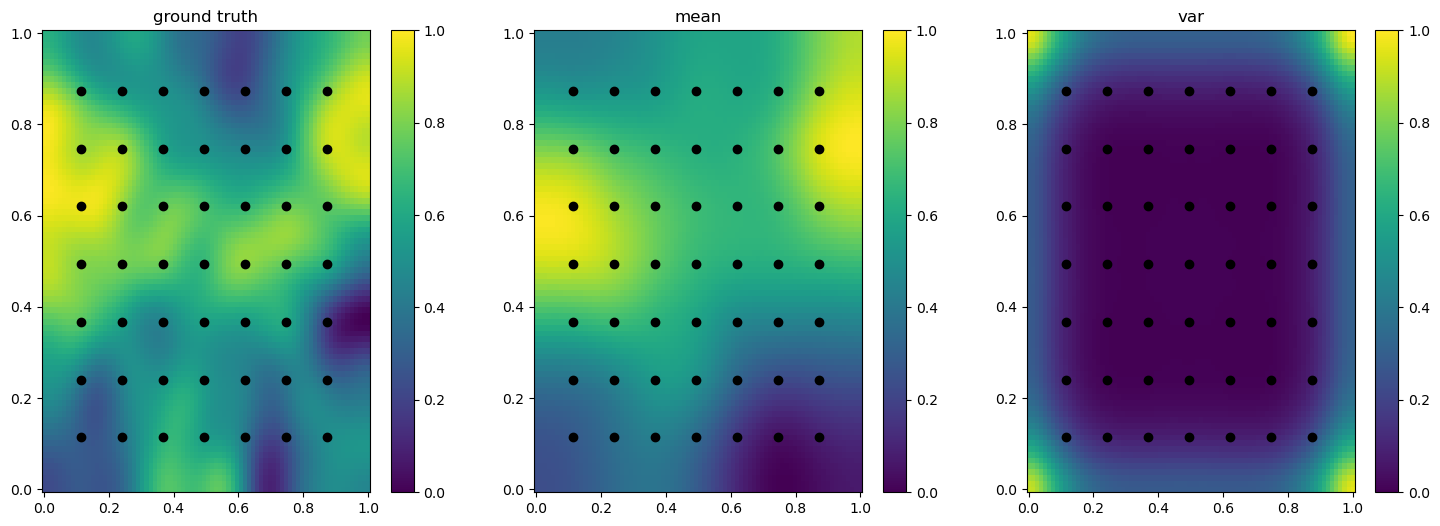

In [4]:
plt.figure(figsize=(18,6))
# adding first subplot
plt.subplot(131)
plt.pcolormesh(X, Y, ref)
plt.scatter(obs_pos_X, obs_pos_Y, color="black")

plt.title("ground truth")
plt.colorbar()
# adding second subplot
plt.subplot(132)
plt.pcolormesh(X, Y, mean_sol2d)
plt.scatter(obs_pos_X, obs_pos_Y, color="black")
plt.title("mean")
plt.colorbar()

plt.subplot(133)
plt.pcolormesh(X, Y, var_sol2d)
plt.scatter(obs_pos_X, obs_pos_Y, color="black")
plt.title("var")
plt.colorbar()

plt.show()